# 1. Introduction


This project demonstrates how to fine-tune a pre-trained BERT model (bert-base-cased) for sentiment classification of app reviews.

We use PyTorch and the Hugging Face Transformers library to train a text classifier that categorizes reviews into one of the following classes:

**Positive**

**Neutral**

**Negative**

**Key highlights:**

The dataset consists of real user reviews from the Google Play Store.

We apply stratified train/validation/test splits to maintain class balance.

BERT is fine-tuned end-to-end with dropout regularization and learning rate scheduling.

The final model achieves ~86% accuracy on the test set.

We visualize performance using a confusion matrix and demonstrate prediction on custom text inputs

# 2. Installing & Importing Libraries


In [ ]:
!pip install transformers==4.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.17.6 requires transformers>=4.33.1, but you have transformers 4.28.1 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.1 which 

In [ ]:

# Hugging Face Transformers (for BERT and tokenization)
import transformers
from transformers import (
    BertModel,
    BertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)

# Core PyTorch libraries
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Data handling and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Utilities
from collections import defaultdict
from textwrap import wrap

# ----------------------------- #
# Notebook Settings for Visualization
# ----------------------------- #
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set seaborn styling and custom color palette
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE", "#FFDD00", "#FF7D00",
    "#FF006D", "#ADFF02", "#8F00FF"
]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# ----------------------------- #
# Set Random Seed for Reproducibility
# ----------------------------- #
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ----------------------------- #
# Select Device (GPU if available)
# ----------------------------- #
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


2025-07-13 05:28:47.741820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752384527.947919      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752384528.005442      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda:0


#  Loading the Dataset

In [ ]:
# Download dataset files from Google Drive
!gdown 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv


Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /kaggle/working/apps.csv
100%|████████████████████████████████████████| 134k/134k [00:00<00:00, 97.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /kaggle/working/reviews.csv
100%|██████████████████████████████████████| 7.17M/7.17M [00:00<00:00, 55.3MB/s]


In [ ]:
# Load dataset
df = pd.read_csv("reviews.csv")
df.head()


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
# Check dataset shape
df.shape  # (15746, 11)


(15746, 11)

In [ ]:
# Dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


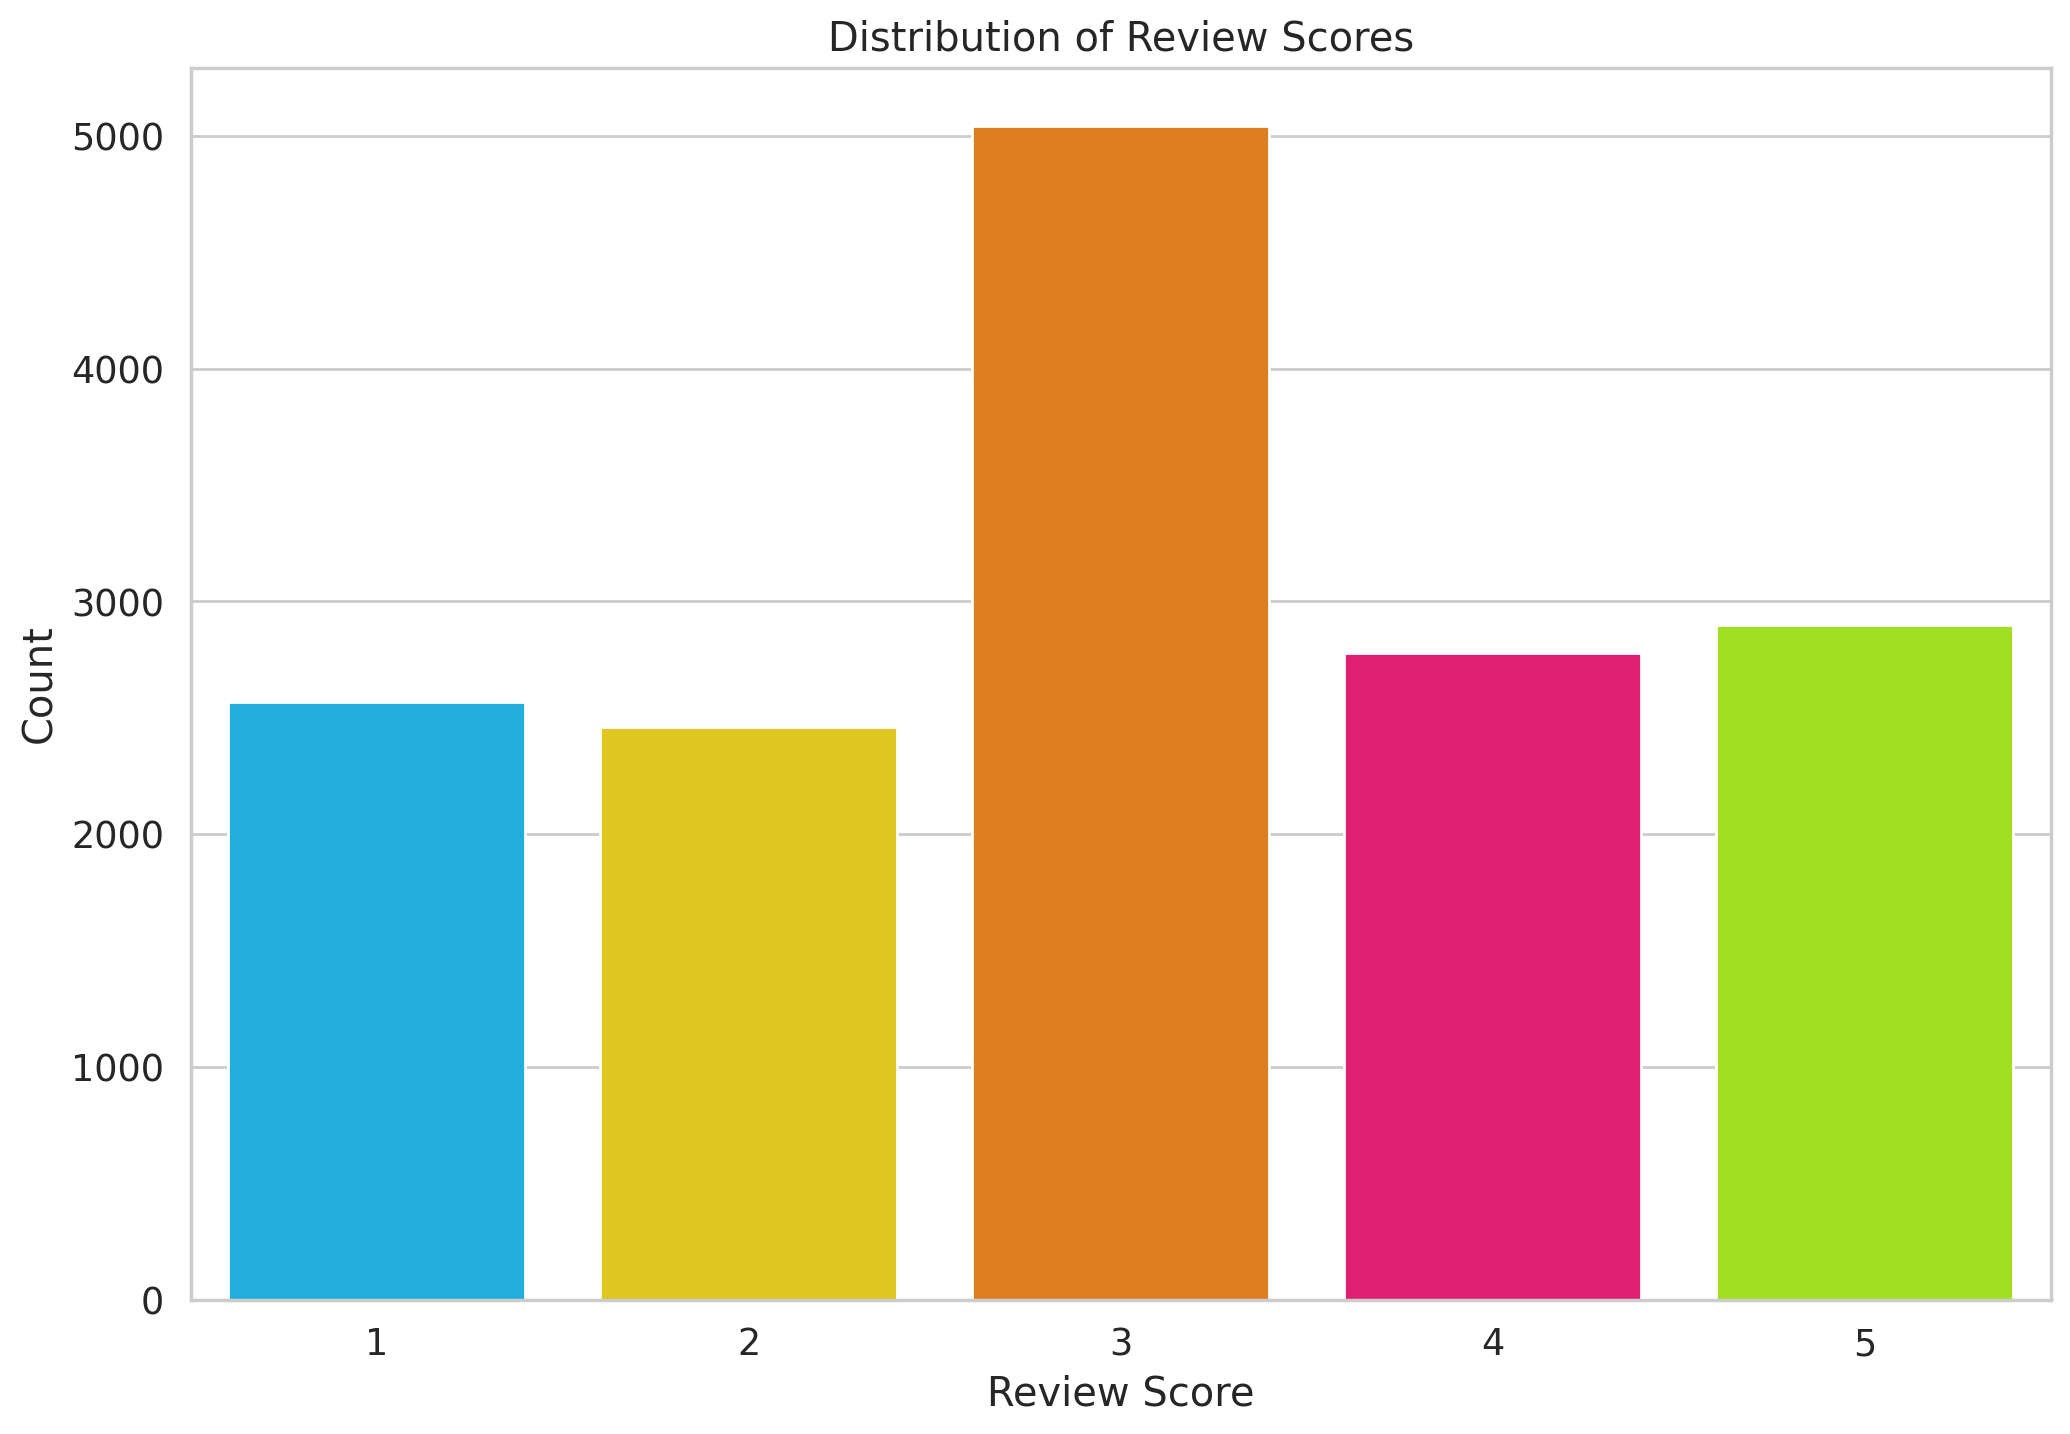

In [ ]:
#Plot distribution of review scores
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
sns.countplot(data=df, x='score')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Distribution of Review Scores')
plt.show()

# 4. Data Preprocessing.

In [ ]:
# Convert review scores to sentiment labels
# 0 = negative, 1 = neutral, 2 = positive
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df['score'].apply(to_sentiment)


In [ ]:
# Sentiment label names for reference
class_names = ['negative', 'neutral', 'positive']


In [ ]:
df.shape

(15746, 12)

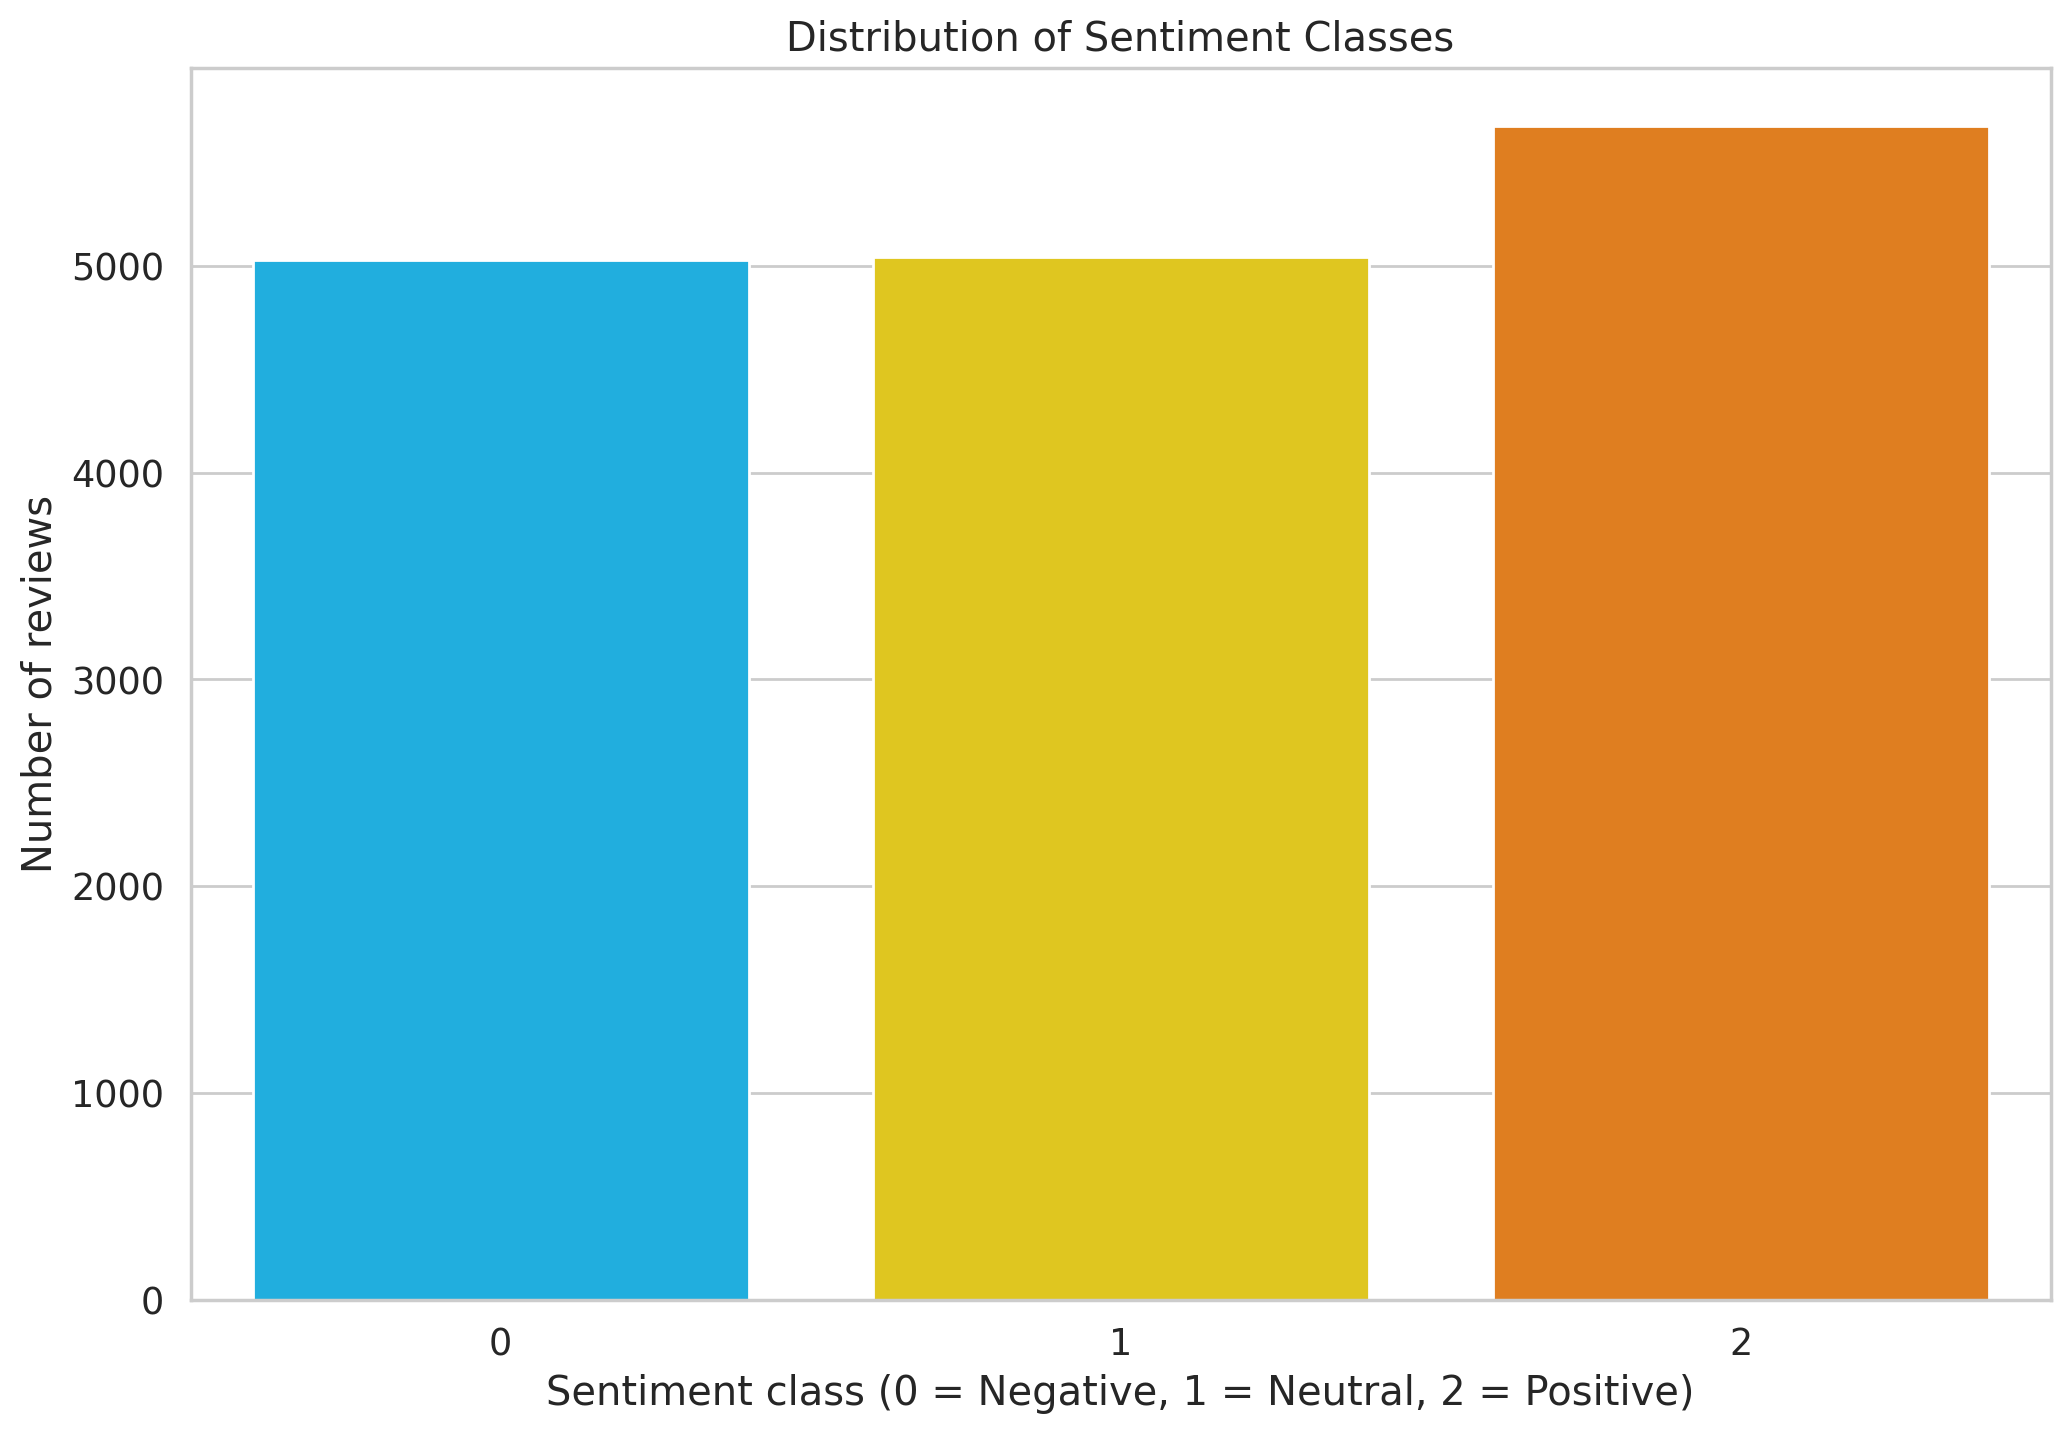

In [ ]:
# Plot distribution of sentiment classes
sns.countplot(x=df['sentiment'])
plt.xlabel('Sentiment class (0 = Negative, 1 = Neutral, 2 = Positive)')
plt.ylabel('Number of reviews')
plt.title('Distribution of Sentiment Classes')
plt.show()


In [ ]:
# Use pre-trained BERT model (case-sensitive)
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'


In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Sample sentence to test tokenizer
sample_txt = "I absolutely loved the product! Will buy again for sure."


In [ ]:
# Tokenize the sample sentence and convert tokens to IDs
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Display original sentence, tokens, and token IDs
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')


 Sentence: I absolutely loved the product! Will buy again for sure.
   Tokens: ['I', 'absolutely', 'loved', 'the', 'product', '!', 'Will', 'buy', 'again', 'for', 'sure', '.']
Token IDs: [146, 7284, 3097, 1103, 3317, 106, 3100, 4417, 1254, 1111, 1612, 119]


In [ ]:
# Special tokens used by BERT and their IDs
print(f"SEP token: {tokenizer.sep_token} — ID: {tokenizer.sep_token_id}")
print(f"CLS token: {tokenizer.cls_token} — ID: {tokenizer.cls_token_id}")
print(f"PAD token: {tokenizer.pad_token} — ID: {tokenizer.pad_token_id}")
print(f"UNK token: {tokenizer.unk_token} — ID: {tokenizer.unk_token_id}")


SEP token: [SEP] — ID: 102
CLS token: [CLS] — ID: 101
PAD token: [PAD] — ID: 0
UNK token: [UNK] — ID: 100


In [ ]:
# Encode the sample sentence using BERT tokenizer
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,      # Add [CLS] and [SEP]
    return_token_type_ids=False,  # Not needed for single sentence tasks
    padding='max_length',         # Pad to fixed length
    truncation=True,              # Truncate if longer than max_length
    return_attention_mask=True,   # Generate attention mask
    return_tensors='pt'           # Return PyTorch tensors
)

# Display the keys returned in the encoding dictionary
print(encoding.keys())


dict_keys(['input_ids', 'attention_mask'])


In [ ]:
# Check length of input IDs (should match max_length)
print(len(encoding['input_ids'][0]))

# View the actual input IDs tensor
encoding['input_ids'][0]


32


tensor([ 101,  146, 7284, 3097, 1103, 3317,  106, 3100, 4417, 1254, 1111, 1612,
         119,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# Check length of attention mask (should also match max_length)
print(len(encoding['attention_mask'][0]))

# View the attention mask tensor
encoding['attention_mask']


32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Calculate token lengths for all reviews
token_lens = []
for txt in df['content']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


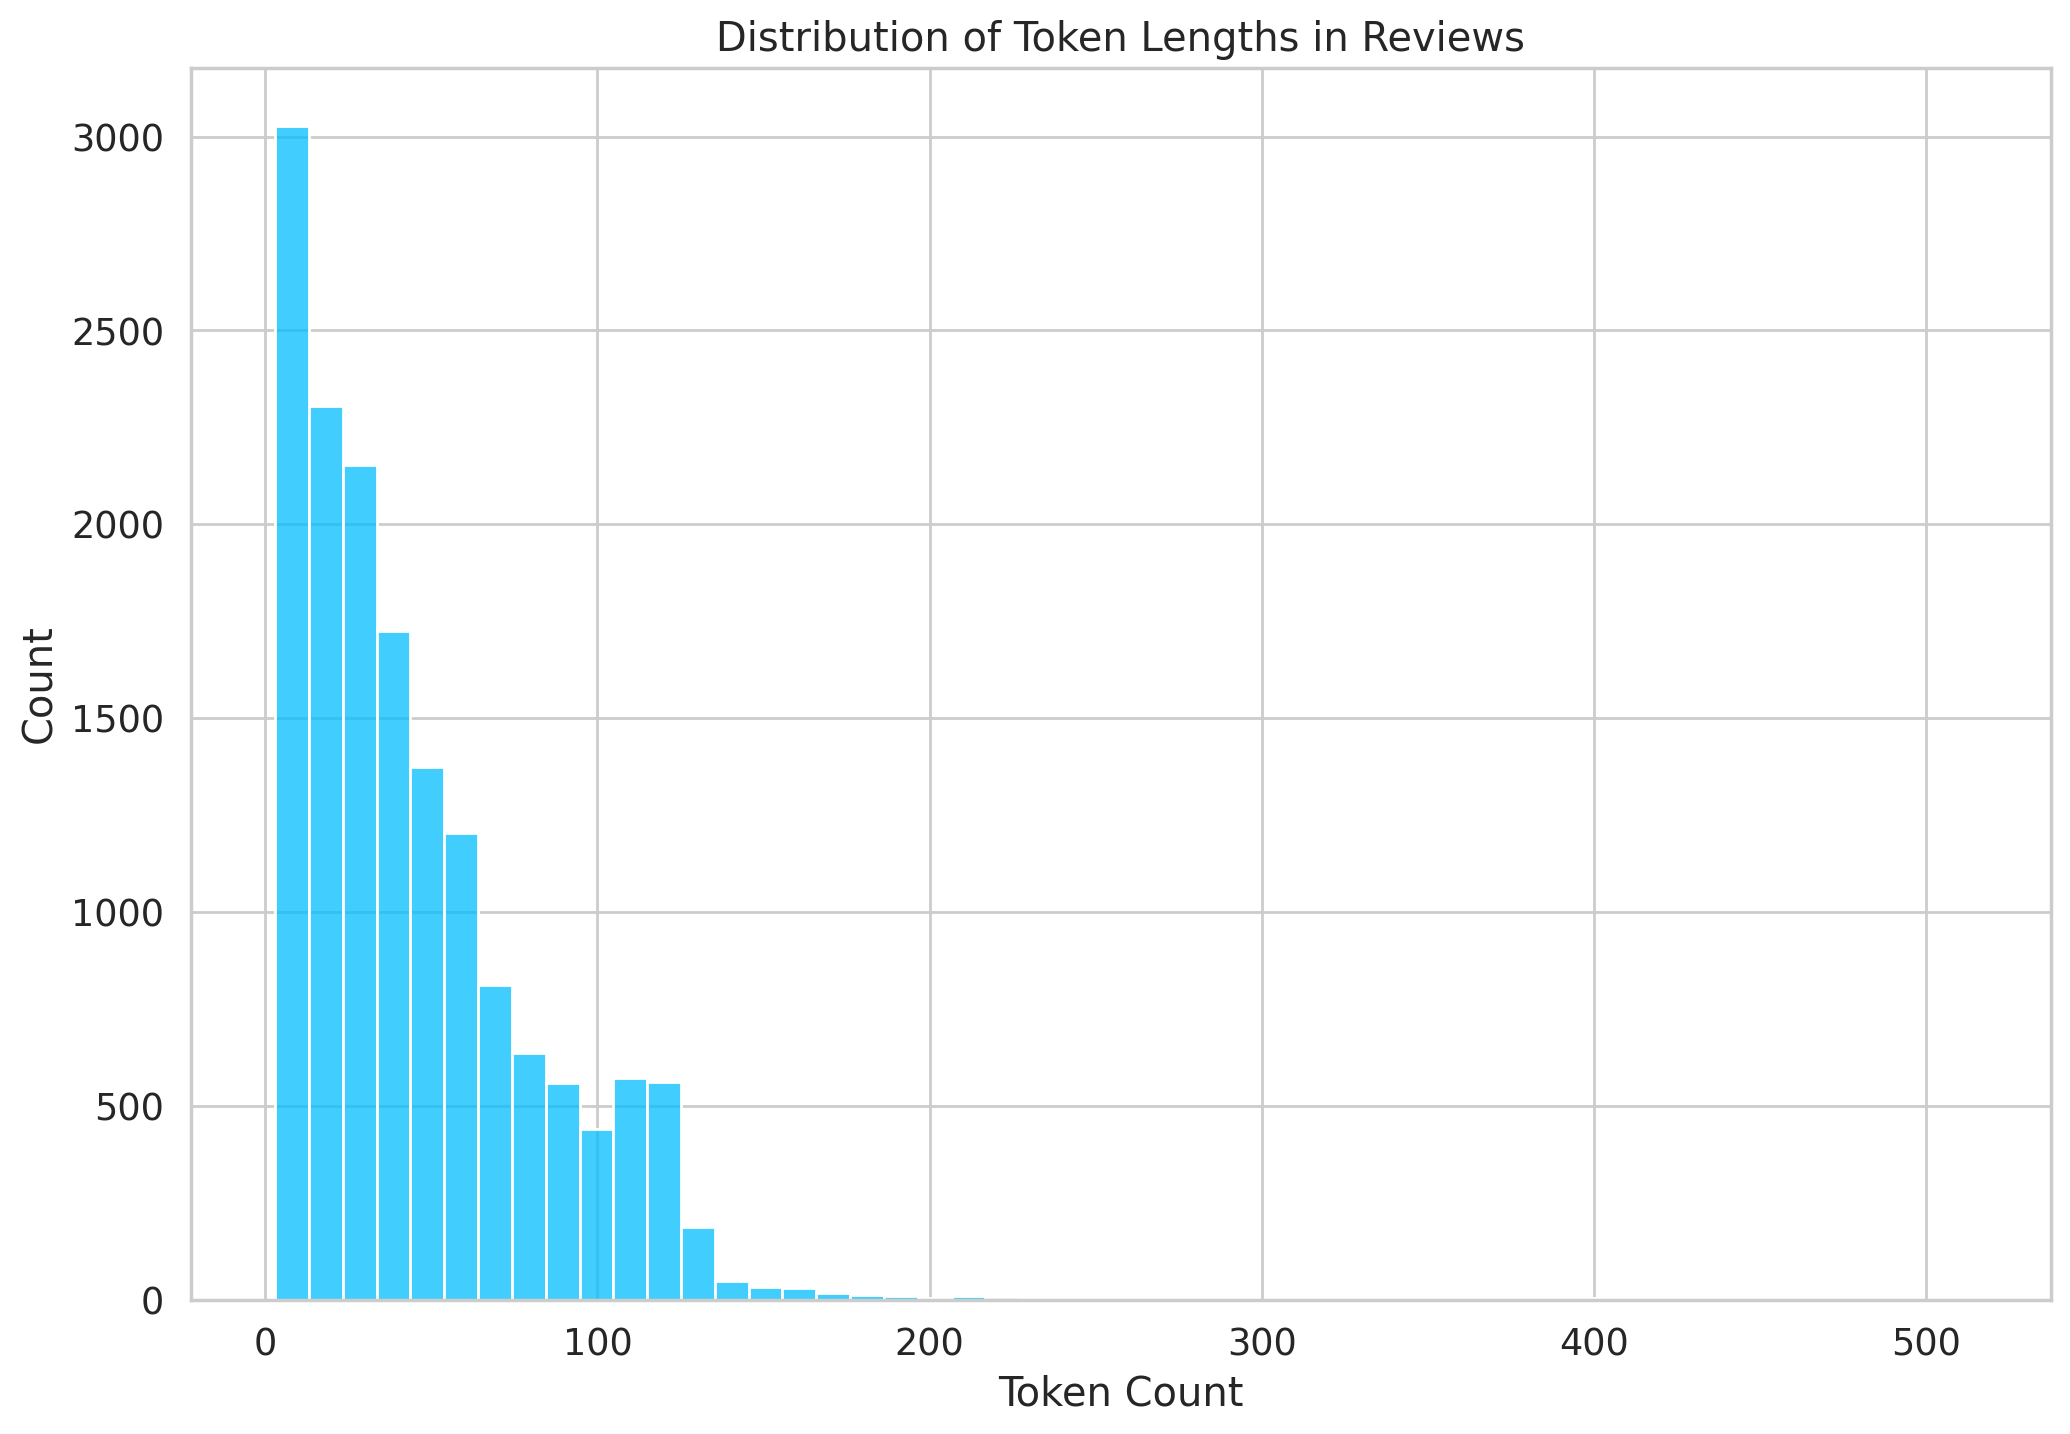

In [ ]:
# Plot distribution of token lengths
sns.histplot(token_lens, bins=50)
plt.xlabel('Token Count')
plt.title('Distribution of Token Lengths in Reviews')
plt.show()


In [ ]:
# Set maximum token length for BERT input
# Most reviews had fewer than 128 tokens, so 160 is a safe upper bound
MAX_LEN = 160


In [ ]:
# Custom Dataset class for review sentiment classification
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews            # List/Series of review texts
        self.targets = targets            # Corresponding sentiment labels
        self.tokenizer = tokenizer        # BERT tokenizer
        self.max_len = max_len            # Max token length (set to 160)

    def __len__(self):
        # Return total number of samples
        return len(self.reviews)

    def __getitem__(self, item):
        # Fetch a single data point
        review = str(self.reviews[item])
        target = self.targets[item]

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,          # Add [CLS] and [SEP]
            max_length=self.max_len,
            return_token_type_ids=False,      # Not needed for single-sentence tasks
            padding='max_length',             # Pad to max_len
            truncation=True,
            return_attention_mask=True,       # Generate attention mask
            return_tensors='pt'               # Return as PyTorch tensors
        )

        # Return dictionary of inputs and target
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),           # Flatten from shape [1, max_len] to [max_len]
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [ ]:
from sklearn.model_selection import train_test_split

#  First split: 80% train, 20% temp (val + test)
df_train, df_temp = train_test_split(
    df,
    test_size=0.2,
    stratify=df['sentiment'],   # Stratify by sentiment label
    random_state=42
)

# Second split: 10% val, 10% test from the 20% temp
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp['sentiment'],  # Stratify again
    random_state=42
)

# 3️⃣ Check shape
print("Train size:", df_train.shape)
print("Validation size:", df_val.shape)
print("Test size:", df_test.shape)


Train size: (12596, 12)
Validation size: (1575, 12)
Test size: (1575, 12)


In [ ]:
# Create DataLoaders for train, validation, and test sets
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,  # Number of samples per batch
        num_workers=2           # Number of subprocesses for data loading
    )

# Set batch size
BATCH_SIZE = 16

# Create DataLoaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader  = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
# Get one batch from the training DataLoader
data = next(iter(train_data_loader))

# Check available keys in the batch dictionary
print(data.keys())

# Check the shape of each input tensor
print(data['input_ids'].shape)        # Expected: [BATCH_SIZE, MAX_LEN]
print(data['attention_mask'].shape)   # Expected: [BATCH_SIZE, MAX_LEN]
print(data['targets'].shape)          # Expected: [BATCH_SIZE]


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Model Definition & Training Setup

In [ ]:
# Load pre-trained BERT base model (uncased)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (init

In [ ]:
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Dropout layer for regularization to avoid overfitting
        self.drop = nn.Dropout(p=0.3)

        # Final linear layer to output logits for each class
        # Input size is BERT's hidden size, output size is number of sentiment classes
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # Pass inputs through BERT model
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Extract the pooled output (embedding of [CLS] token)
        pooled_output = outputs.pooler_output

        # Apply dropout for regularization
        output = self.drop(pooled_output)

        # Pass through final classification layer to get logits
        return self.out(output)


In [ ]:
# Initialize the sentiment classification model with the number of output classes
model = SentimentClassifier(n_classes=len(class_names))

# Move the model to the selected device (GPU if available, else CPU)
model = model.to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Get one batch of data from the training DataLoader
data = next(iter(train_data_loader))

# Move input IDs and attention masks tensors to the selected device (GPU or CPU)
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


In [ ]:
import torch.nn.functional as F

# Disable gradient computation — this is inference, not training
with torch.no_grad():
    # Forward pass: obtain raw output logits from the model
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Apply softmax to get class probabilities from logits
    probs = F.softmax(outputs, dim=1)

    # Inspect shape and values of output
    print("Output logits shape:", outputs.shape)    # e.g. [batch_size, num_classes]
    print("Predicted probabilities:", probs)


Output logits shape: torch.Size([16, 3])
Predicted probabilities: tensor([[0.3219, 0.2574, 0.4207],
        [0.3123, 0.1731, 0.5146],
        [0.1856, 0.1764, 0.6381],
        [0.1742, 0.3969, 0.4288],
        [0.2275, 0.3496, 0.4229],
        [0.2803, 0.2474, 0.4723],
        [0.2668, 0.3374, 0.3957],
        [0.2701, 0.2628, 0.4670],
        [0.1769, 0.2670, 0.5561],
        [0.2193, 0.2201, 0.5605],
        [0.3000, 0.2047, 0.4953],
        [0.3607, 0.2497, 0.3896],
        [0.4914, 0.1656, 0.3430],
        [0.2997, 0.3208, 0.3795],
        [0.1716, 0.1798, 0.6485],
        [0.3491, 0.2315, 0.4194]], device='cuda:0')


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

#  Set remaining epochs (e.g. training Epochs 7–10 means 4 remaining)
EPOCHS = 10

# 🔁 Reinitialize the optimizer with lower learning rate (fine-tuning step)
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

# 🔁 Update total training steps for scheduler based on remaining epochs
total_steps = len(train_data_loader) * EPOCHS

# 🔁 Reinitialize scheduler to match new optimizer and steps
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# ✅ Loss function stays the same
loss_fn = nn.CrossEntropyLoss().to(device)


# Model Training & Evaluation

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()  # Set model to training mode
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)  # Predicted class

    loss = loss_fn(outputs, targets)  # Compute loss
    correct_predictions += torch.sum(preds == targets)  # Count correct
    losses.append(loss.item())

    loss.backward()  # Backpropagation
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
    optimizer.step()       # Update weights
    scheduler.step()       # Adjust learning rate
    optimizer.zero_grad()  # Reset gradients

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    losses = []
    correct_predictions = 0

    with torch.no_grad():  # No gradient calculation needed during evaluation
        for d in data_loader:
            input_ids = d["input_ids"].to(device)             # Move input IDs to GPU/CPU
            attention_mask = d["attention_mask"].to(device)   # Move attention mask to GPU/CPU
            targets = d["targets"].to(device)                 # Move target labels to GPU/CPU

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)              # Get predicted class (highest logit)
            loss = loss_fn(outputs, targets)                  # Compute loss
            correct_predictions += torch.sum(preds == targets)  # Count correct predictions
            losses.append(loss.item())                        # Save loss for averaging

    # Return overall accuracy and average loss
    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
%%time

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Training step
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}')

    # Validation step
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}\n')

    # Save metrics
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss: 0.7413 | Accuracy: 0.6624
Val   loss: 0.6110 | Accuracy: 0.7390

Epoch 2/10
----------
Train loss: 0.4480 | Accuracy: 0.8258
Val   loss: 0.5628 | Accuracy: 0.7962

Epoch 3/10
----------
Train loss: 0.2508 | Accuracy: 0.9170
Val   loss: 0.7005 | Accuracy: 0.8279

Epoch 4/10
----------
Train loss: 0.1619 | Accuracy: 0.9505
Val   loss: 0.8328 | Accuracy: 0.8362

Epoch 5/10
----------
Train loss: 0.1138 | Accuracy: 0.9671
Val   loss: 0.9258 | Accuracy: 0.8451

Epoch 6/10
----------
Train loss: 0.0763 | Accuracy: 0.9779
Val   loss: 1.0116 | Accuracy: 0.8444

Epoch 7/10
----------
Train loss: 0.0673 | Accuracy: 0.9803
Val   loss: 1.0273 | Accuracy: 0.8521

Epoch 8/10
----------
Train loss: 0.0559 | Accuracy: 0.9825
Val   loss: 1.0505 | Accuracy: 0.8590

Epoch 9/10
----------
Train loss: 0.0428 | Accuracy: 0.9852
Val   loss: 1.0917 | Accuracy: 0.8571

Epoch 10/10
----------
Train loss: 0.0374 | Accuracy: 0.9869
Val   loss: 1.1154 | Accuracy: 0.8578

CPU times

# Evaluation & Visualization

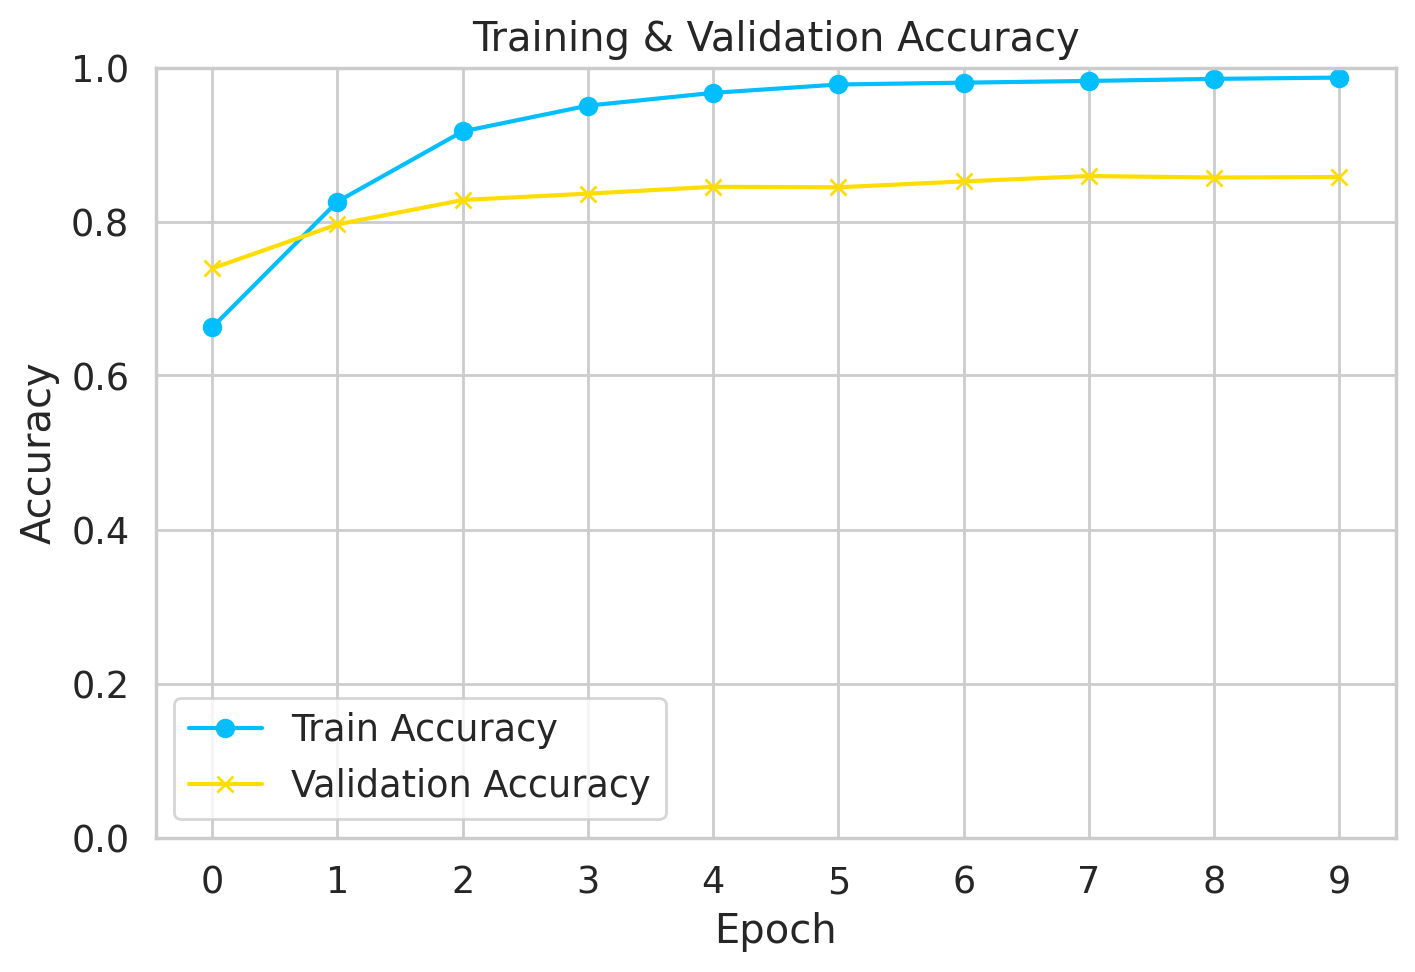

In [ ]:
import matplotlib.pyplot as plt
import torch

# Convert accuracy tensors (if on GPU) to CPU floats
train_acc = [x.cpu().item() if torch.is_tensor(x) else x for x in history['train_acc']]
val_acc = [x.cpu().item() if torch.is_tensor(x) else x for x in history['val_acc']]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='x')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])  # Accuracy range
plt.xticks(range(len(train_acc)))  # Ensure all epochs are shown
plt.show()


In [ ]:
print("Train accs:", train_acc)
print("Val accs:", val_acc)


Train accs: [0.6623531279771356, 0.8258177199110829, 0.9169577643696412, 0.9504604636392506, 0.9670530327087965, 0.9779295014290251, 0.9803112099079073, 0.9825341378215307, 0.9852334074309305, 0.986900603366148]
Val accs: [0.7390476190476191, 0.7961904761904762, 0.827936507936508, 0.8361904761904762, 0.8450793650793651, 0.8444444444444444, 0.8520634920634921, 0.8590476190476191, 0.8571428571428571, 0.8577777777777778]


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.8641269841269841

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
# Run model on test data to get predictions and related info
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)


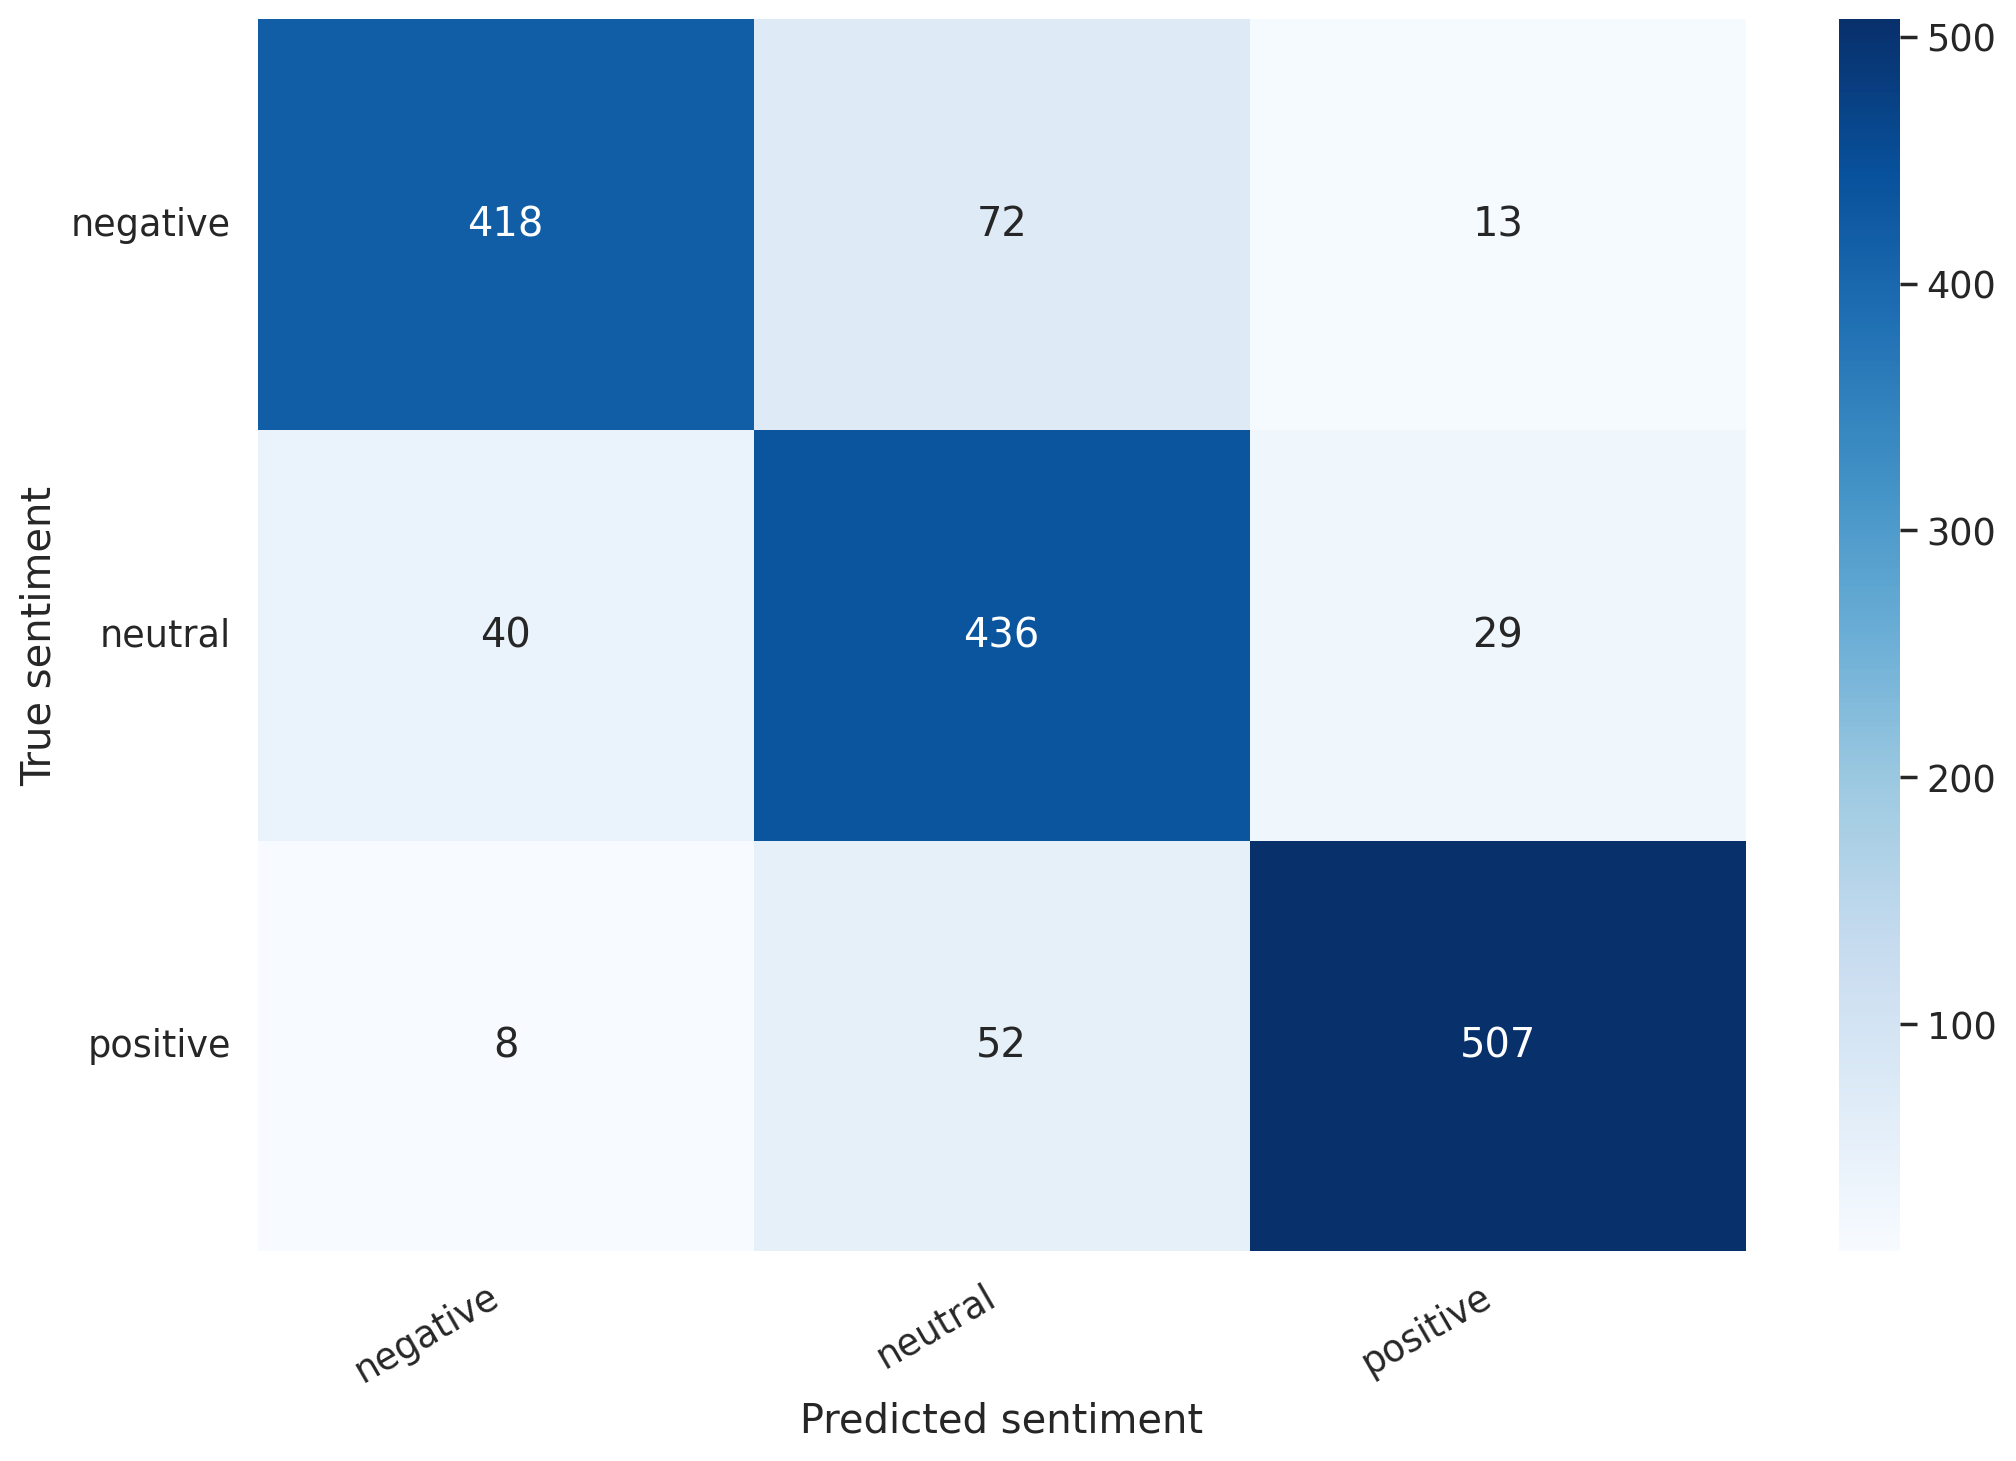

In [ ]:
# Function to display the confusion matrix as a heatmap
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

# Generate and format confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# Show confusion matrix
show_confusion_matrix(df_cm)


# Test Set Sample Predictions

In [ ]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

One of the main sticking points for me is how well an app does
recurring tasks. In particular, not just fixed date recurrences, but
the ability to set the next date off the last completion date. So many
apps fail to offer this. Alas, I could find NO way to do a recurring
task at all, in spite of them saying it can be done. So, much less
checking on this nuance, I see no way of doing them at all. Fail.
Moving on.

True sentiment: negative


# Raw Data Prediction

In [ ]:
# Making predictions on raw text.
review_text = "This app makes organizing my tasks so easy and fun. Absolutely love using it every day!"


In [ ]:
# Encode raw review text into BERT input format
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt'
)


In [ ]:
import torch.nn.functional as F

# Move inputs to the device
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

# Get model output
output = model(input_ids, attention_mask)

# Apply softmax to convert logits to probabilities
probs = F.softmax(output, dim=1)

# Get predicted class
_, prediction = torch.max(probs, dim=1)

# Display review, predicted sentiment, and probabilities
print(f"Review text     : {review_text}")
print(f"Predicted label : {class_names[prediction]}")
print(f"Class probabilities:")
for i, prob in enumerate(probs[0]):
    print(f"  {class_names[i]}: {prob.item():.4f}")


Review text     : This app makes organizing my tasks so easy and fun. Absolutely love using it every day!
Predicted label : positive
Class probabilities:
  negative: 0.0000
  neutral: 0.0001
  positive: 0.9999
